## Preparing the data set

The first step before running the clustering algorithm is to prepare the training and the testing data set. 


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid", color_codes=True)
sns.palplot(sns.color_palette("RdBu", n_colors=7))

fileNameTrain = "C:\\Users\\sevda\\Documents\\Data Lab\\Six sigma rental property\\train.json\\train.json"
train_df = pd.read_json(fileNameTrain)

fileNameTest = "C:\\Users\\sevda\\Documents\\Data Lab\\Six sigma rental property\\test.json\\test.json"
test_df = pd.read_json(fileNameTest)

#train_df.head()
print(train_df.axes)
print(test_df.axes)


[Int64Index([    10,  10000, 100004, 100007, 100013, 100014, 100016, 100020,
            100026, 100027,
            ...
             99982,  99984,  99986,  99987,  99988,   9999,  99991,  99992,
             99993,  99994],
           dtype='int64', length=49352), Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'listing_id', 'longitude', 'manager_id', 'photos', 'price',
       'street_address'],
      dtype='object')]
[Int64Index([     0,      1,    100,   1000, 100000, 100001, 100002, 100003,
            100005, 100006,
            ...
             99981,  99983,  99985,  99989,  99990,  99995,  99996,  99997,
             99998,  99999],
           dtype='int64', length=74659), Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address'],


In [6]:
lower_limit_lon = np.percentile(train_df.longitude.values, 1)
upper_limit_lon = np.percentile(train_df.longitude.values, 99)
train_df['longitude'].ix[train_df['longitude']<lower_limit_lon] = lower_limit_lon
train_df['longitude'].ix[train_df['longitude']>upper_limit_lon] = upper_limit_lon
test_df['longitude'].ix[test_df['longitude']<lower_limit_lon] = lower_limit_lon
test_df['longitude'].ix[test_df['longitude']>upper_limit_lon] = upper_limit_lon

lower_limit_lat = np.percentile(train_df.latitude.values, 1)
upper_limit_lat = np.percentile(train_df.latitude.values, 99)
train_df['latitude'].ix[train_df['latitude']<lower_limit_lat] = lower_limit_lat
train_df['latitude'].ix[train_df['latitude']>upper_limit_lat] = upper_limit_lat
test_df['latitude'].ix[test_df['latitude']<lower_limit_lat] = lower_limit_lat
test_df['latitude'].ix[test_df['latitude']>upper_limit_lat] = upper_limit_lat

In [7]:
import shapefile

sf = shapefile.Reader("C:\\Users\\sevda\\Documents\\Data Lab\\Six sigma rental property\\ZillowNeighborhoods-NY\\ZillowNeighborhoods-NY.shp")

shapes = sf.shapes()
records = sf.records()

towns_values = [records[i][2] for i in range(len(records))]
neighb_values = [records[i][3] for i in range(len(records))]
west_values = [shapes[i].bbox[0] for i in range(len(records))]
south_values = [shapes[i].bbox[1] for i in range(len(records))]
east_values = [shapes[i].bbox[2] for i in range(len(records))]
north_values = [shapes[i].bbox[3] for i in range(len(records))]

west, south, east, north = -74.02, 40.64, -73.85, 40.86

neighbourhood_pd = pd.DataFrame({'Town' : towns_values,
                                 'Neighbourhood' : neighb_values,
                                 'West' : west_values,
                                 'South' : south_values,
                                 'East' : east_values,
                                 'North' : north_values})

neighbourhood_pd = neighbourhood_pd[neighbourhood_pd.Town == "New York"]
neighbourhood_pd = neighbourhood_pd.ix[(neighbourhood_pd.West >= west) & 
                                     (neighbourhood_pd.East <= east) & 
                                     (neighbourhood_pd.South >= south) & 
                                     (neighbourhood_pd.North <= north)]

neighbourhood_sorted_pd = neighbourhood_pd.sort_values(['West'])


neighbourhood_ls = []
for num in range(0, train_df.shape[0]):
    temp = neighbourhood_sorted_pd[(neighbourhood_sorted_pd.West<train_df.longitude.values[num]) &
                                   (neighbourhood_sorted_pd.East>train_df.longitude.values[num]) &
                                   (neighbourhood_sorted_pd.South<train_df.latitude.values[num]) &
                                   (neighbourhood_sorted_pd.North>train_df.latitude.values[num])]
    if temp.shape[0] > 0:
        neighbourhood_ls += [temp.Neighbourhood.values[0]]
    else:
        neighbourhood_ls += ["Other"]
    
train_df['neighbourhood'] = pd.Series(neighbourhood_ls, index=train_df.index)

neighbourhood_ls = []
for num in range(0, test_df.shape[0]):
    temp = neighbourhood_sorted_pd[(neighbourhood_sorted_pd.West<test_df.longitude.values[num]) &
                                   (neighbourhood_sorted_pd.East>test_df.longitude.values[num]) &
                                   (neighbourhood_sorted_pd.South<test_df.latitude.values[num]) &
                                   (neighbourhood_sorted_pd.North>test_df.latitude.values[num])]
    if temp.shape[0] > 0:
        neighbourhood_ls += [temp.Neighbourhood.values[0]]
    else:
        neighbourhood_ls += ["Other"]
    
test_df['neighbourhood'] = pd.Series(neighbourhood_ls, index=test_df.index)

As a next step, we will extract the key words from the description variable - by key words, we define words that are in the description of the unit but are not stop words as defined by the ntlk.corpus package.

In [8]:
from nltk.corpus import stopwords

cachedStopWords = stopwords.words("english")

description_key_words_ls = []

for ind, row in train_df.iterrows():
        #print(row['features'])
        #description = description.lower()
        description = row['description'].lower().rstrip(',?!.')
        description = ' '.join([word for word in description.split() if word not in cachedStopWords])
        description_ls = description.split(" ")
        description_key_words_ls += [description_ls]

train_df['description_key_words'] = pd.Series(description_key_words_ls, index=train_df.index)

description_key_words_ls = []

for ind, row in test_df.iterrows():
        #print(row['features'])
        #description = description.lower()
        description = row['description'].lower().rstrip(',?!.')
        description = ' '.join([word for word in description.split() if word not in cachedStopWords])
        description_ls = description.split(" ")
        description_key_words_ls += [description_ls]

test_df['description_key_words'] = pd.Series(description_key_words_ls, index=test_df.index)

We will create two numeric variables which describe the number of features and number of key words in the description section

In [9]:
train_df['num_features'] = train_df.features.apply(len)
train_df['num_key_words_description'] = train_df.description_key_words.apply(len)

test_df['num_features'] = test_df.features.apply(len)
test_df['num_key_words_description'] = test_df.description_key_words.apply(len)

From the Created variable, we will extract into new variables the exact data when the listing was created, the day of year, week of year, weekday and hour.

In [10]:
train_df["created"] = pd.to_datetime(train_df["created"])
train_df["date"]= train_df["created"].dt.date

train_df["dayofyear"] = train_df["created"].dt.dayofyear
train_df["weekofyear"] = train_df["created"].dt.weekofyear
train_df["weekday"] = train_df["created"].dt.weekday
train_df["hour"] = train_df["created"].dt.hour

test_df["created"] = pd.to_datetime(test_df["created"])
test_df["date"]= test_df["created"].dt.date

test_df["dayofyear"] = test_df["created"].dt.dayofyear
test_df["weekofyear"] = test_df["created"].dt.weekofyear
test_df["weekday"] = test_df["created"].dt.weekday
test_df["hour"] = test_df["created"].dt.hour

The train and the test data set are ready so the next step is to apply the XGBoost algorithm.


In [12]:
print(train_df.price.values)

[3000 5465 2850 ..., 2595 3350 2200]


In [36]:
import os
import sys
import operator
import numpy as np
import pandas as pd
from scipy import sparse
import xgboost as xgb
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=1000):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model


selected_vars  = ["bathrooms", "bedrooms", "price", "num_features", "num_key_words_description",
                   "dayofyear", "weekofyear", "weekday", "hour"]

In [45]:
selected_vars  = ["bathrooms", "bedrooms", "price", "num_features", "num_key_words_description",
                   "dayofyear", "weekofyear", "weekday", "hour"]
train_X = train_df[selected_vars]
test_X = test_df[selected_vars]

target_num_map = {'high':0, 'medium':1, 'low':2}
#train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
train_y = pd.DataFrame(train_df['interest_level'].apply(lambda x: target_num_map[x]))
print(train_X.shape, test_X.shape)

preds, model = runXGB(train_X, train_y, test_X, num_rounds=400)
out_df = pd.DataFrame(preds)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test_df.listing_id.values

print (out_df.head())
print(type(preds))

(49352, 9) (74659, 9)
       high    medium       low  listing_id
0  0.047830  0.386779  0.565391     7142618
1  0.075124  0.243756  0.681121     7210040
2  0.004342  0.078086  0.917572     7103890
3  0.044818  0.398743  0.556439     7143442
4  0.008197  0.129960  0.861842     6860601
<class 'numpy.ndarray'>


In [48]:
print(preds)


[[ 0.04783038  0.38677871  0.56539088]
 [ 0.0751239   0.2437555   0.68112057]
 [ 0.00434199  0.07808571  0.91757238]
 ..., 
 [ 0.12455944  0.2891759   0.58626461]
 [ 0.5298695   0.3289555   0.14117494]
 [ 0.08227518  0.3746722   0.54305261]]


In [107]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

def modelXGBfit(train_df, test_df, predictors, target, target_num_map, useTrainCV= False, cv_folds=5, early_stopping_rounds=50):
    
    alg = XGBClassifier(
                     learning_rate =0.1,
                     n_estimators=1000,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'multi:softprob; num_class=3',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        train_target = pd.DataFrame(train_df['interest_level'].apply(lambda x: target_num_map[x]))
        xgtrain = xgb.DMatrix(train_df[predictors].values, label=train_target)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    #alg.set_params(n_estimators = 3)
    train_target = pd.DataFrame(train_df['interest_level'].apply(lambda x: target_num_map[x]))
    alg.fit(train_df[predictors], train_target)
        
    #Predict training set:
    train_predictions = alg.predict(train_df[predictors])
    train_predprob = alg.predict_proba(train_df[predictors])
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(train_target, train_predictions))
   # print ("Train_df target: " + train_df[target].values[1:10])
   # print (type(train_df[target]))
   # print ("Train predicted prob:" + train_predprob.values[1:10])
   # print (type(train_predprob))
    # print ("AUC Score (Train): %f" % metrics.roc_auc_score(train_df[target].values, train_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()
    
    #Predicting on the test data set
    test_predictions = alg.predict(test_df[predictors])
    test_predprob = alg.predict_proba(test_df[predictors])
    #pred_test_y = model.predict(train_df[predictors])
    return test_predictions, test_predprob, alg



Model Report
Accuracy : 0.8116


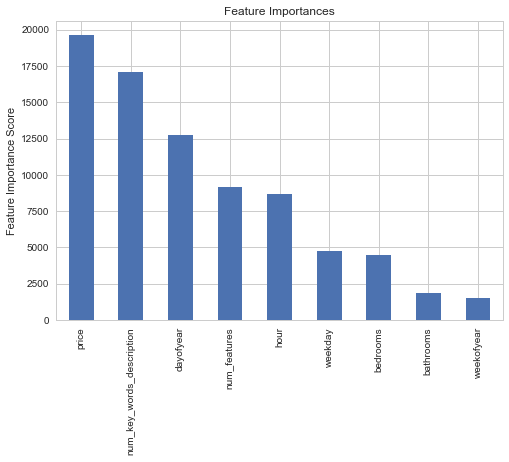

In [108]:
selected_vars  = ["bathrooms", "bedrooms", "price", "num_features", "num_key_words_description",
                   "dayofyear", "weekofyear", "weekday", "hour"]
target = "interest_level"
target_num_map = {'high':0, 'medium':1, 'low':2}

test_prediction, test_predprob, alg = modelXGBfit (train_df, test_df, selected_vars, target, target_num_map)

In [68]:
alg = XGBClassifier()
alg.get_params().keys()

dict_keys(['base_score', 'colsample_bylevel', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'nthread', 'objective', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample'])

In [109]:
#result_df = pd.DataFrame(test_predprob)
#result_df.columns = ["high", "medium", "low"]
#result_df["listing_id"] = test_df.listing_id.values
print(test_predprob)
print(train_df.shape)
print(test_df.shape)

[[ 0.04682983  0.36960143  0.58356875]
 [ 0.11322674  0.22651519  0.66025805]
 [ 0.00334237  0.08096866  0.91568893]
 ..., 
 [ 0.16106729  0.30375481  0.53517789]
 [ 0.4198705   0.52691084  0.05321866]
 [ 0.06705491  0.38945648  0.54348862]]
(49352, 24)
(74659, 23)


In [49]:
cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
        print(dev_index)
        print(type(train_X))
        print(type(train_y))
        dev_X, val_X = train_X.iloc[dev_index], train_X.iloc[val_index]
        dev_y, val_y = train_y.iloc[dev_index], train_y.iloc[val_index]
        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
        cv_scores.append(log_loss(val_y, preds))
        print(cv_scores)
        break

[    0     1     2 ..., 49347 49350 49351]
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
[0]	train-mlogloss:1.04666	test-mlogloss:1.04704
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:1.00314	test-mlogloss:1.0036
[2]	train-mlogloss:0.960191	test-mlogloss:0.961036
[3]	train-mlogloss:0.924198	test-mlogloss:0.925564
[4]	train-mlogloss:0.892945	test-mlogloss:0.894629
[5]	train-mlogloss:0.867921	test-mlogloss:0.870195
[6]	train-mlogloss:0.845938	test-mlogloss:0.848788
[7]	train-mlogloss:0.824462	test-mlogloss:0.827865
[8]	train-mlogloss:0.805425	test-mlogloss:0.809175
[9]	train-mlogloss:0.789221	test-mlogloss:0.793306
[10]	train-mlogloss:0.775088	test-mlogloss:0.779623
[11]	train-mlogloss:0.761219	test-mlogloss:0.766187
[12]	train-mlogloss:0.74881	test-mlogloss:0.75426
[13]	train-mlogloss:0.738764	test-mlogloss:0.744689
[14]	train-mlogloss